### imports

In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gpflow
from gpflow.kernels import SquaredExponential, SharedIndependent, SeparateIndependent
from gpflow.inducing_variables import SharedIndependentInducingVariables, InducingPoints
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

from GWP.BANNER.src.models.WishartProcess import WishartProcess
from GWP.BANNER.util.training_util import run_adam
from GWP.BANNER.src.kernels.PartlySharedIndependentMOK import PartlySharedIndependentMultiOutput
from GWP.BANNER.src.likelihoods.WishartProcessLikelihood import WishartLikelihood


## 1 Generate data 

In [35]:
def simulate_wishart_process(D=5, T=10, N=100, A=None, nu=None):
    """
    :param D: Number of observed variables.
    :param T: Length of time series.
    :param N: Number of samples.
    :param A: Cholesky decomposition of the Wishart scaling matrix, i.e. V=AA^T. Defaults to the identity.
    :param nu: The Wishart degrees of freedom. Defaults to D+1.
    :return: A sample from the Wishart process \Sigma(x)
    """

    def sample_gp(X, kernel, nsamples):
        """
        :param X: Input locations.
        :param kernel: GP kernel.
        :param nsamples: Number of samples.
        :return: Generates samples from a GP with known kernel.
        """

        K = kernel.K(X) + 1e-6 * np.eye(N)
        L = np.linalg.cholesky(K)
        z = np.random.normal(size=(N, nsamples))
        return np.dot(L, z)  # N x nsamples

    #
    if A is None:
        A = np.eye(D)

    # Number of latent GPs (aka degrees-of-freedom)
    if nu is None:
        nu = D + 1

    # Generate input
    X = np.tile(np.linspace(0, T, N), (D, 1)).T
   
    # True dynamic properties of each of D variables. We pick some random lengthscales and variances within some bounds.
    true_lengthscale = np.random.permutation(np.linspace(0.05 * T, 0.3 * T, num=D))
    true_variance = 1 + 0.5*np.random.uniform(size=D)

    # The true kernel is a distinct kernel for each latent GP. Across the degrees of freedom (\nu), the same kernel is
    # used.
    kernels = [SquaredExponential(lengthscales=true_lengthscale[i], variance=true_variance[i]) for i in range(D)]

    # Latent GPs
    u = np.zeros((D, nu, N))
    for i in range(D):
        u[i, :, :] = sample_gp(X, kernels[i], nsamples=nu).T

    Sigma = np.zeros((N, D, D))
    for t in range(N):
        Sigma[t, :, :] = np.dot(np.dot(A, np.dot(u[:, :, t], u[:, :, t].T)), A.T)

    return X, Sigma, true_lengthscale, true_variance

def sample_observations(Sigma, mu=None):
    """
    :param Sigma: Generalised Wishart Process, i.e. covariance process
    :param mu: Mean function.
    :return: Returns N x D matrix Y, containing one observation for each 'time point'.
    """

    N, D, _ = Sigma.shape
    if mu is None:
        mu = np.zeros(D)

    Y = np.zeros((N, D))
    for t in range(N):
        Y[t, :] = np.random.multivariate_normal(mean=mu, cov=Sigma[t, :, :])
    return Y

In [140]:
D, N, T = 3, 100, 4.0
X, Sigma_true, true_lengthscale, true_variance = simulate_wishart_process(D=D, T=T, N=N)
Y = sample_observations(Sigma_true)


In [168]:
print(Sigma_true.shape)

(100, 3, 3)


## 2 Wishart inference 


The functions below are used for running the **inference**

In [240]:
def run_wishart_process_inference(data, T, iterations=10000, num_inducing=None, learning_rate=0.01, batch_size=25):
    """

    :param data: Tuple (X, Y) of input and responses.
    :param T: Last timepoint (assume we start at t=0).
    :param iterations: Number of variational inference optimization iterations.
    :param num_inducing: Number of inducing points (inducing points are in the same space as X).
    :param learning_rate: Optimization parameter.
    :param batch_size: Data is split into batches of size batch_size, for stochastic optimization (otherwise we'll run
    out of memory).
    :return: Returns a dictionary with the posterior Wishart process (with trained hyperparameters and variational
    parameters), and a list with the ELBO (loss) per iteration.
    """
    X, Y = data
    N, D = Y.shape
    if num_inducing is None:
        num_inducing = int(0.4 * N)

    model_inverse = False
    additive_noise = True

    nu = D + 1  # Degrees of freedom
    R = 10  # samples for variational expectation
    latent_dim = int(nu * D)

    if num_inducing == N:
        Z_init = tf.identity(X)  # X.copy()
    else:
        Z_init = np.array([np.linspace(0, T, num_inducing) for _ in range(D)]).T   # initial inducing variable locations
    Z = tf.identity(Z_init)
    iv = SharedIndependentInducingVariables(InducingPoints(Z))  # multi output inducing variables

    kernel_type = 'shared'  # ['shared', 'separate', 'partially_shared']   # shares the same kernel parameters across input dimension
    kernel = SquaredExponential(lengthscales=5.)

    if kernel_type == 'shared':
        kernel = SharedIndependent(kernel, output_dim=latent_dim)
    elif kernel_type == 'separate':
        kernel = SeparateIndependent([SquaredExponential(lengthscales=1. - (i + 6) * 0.01) for i in range(latent_dim)])
    elif kernel_type == 'partially_shared':
        kernel = PartlySharedIndependentMultiOutput([SquaredExponential(lengthscales=0.5 + i * 0.5) for i in range(D)], nu=nu)
    else:
        raise NotImplementedError

    # likelihood
    likelihood = WishartLikelihood(D, nu, R=R, additive_noise=additive_noise, model_inverse=model_inverse)
    # create GWP model

    wishart_process = WishartProcess(kernel, likelihood, D=D, nu=nu, inducing_variable=iv)

    # If num_inducing==N, we do not actually have inducing points.
    if num_inducing == N:
        gpflow.set_trainable(wishart_process.inducing_variable, False)

    elbo = run_adam(wishart_process, data, ci_niter(iterations), learning_rate, batch_size, natgrads=False, pb=True)
    return {'wishart process': wishart_process, 'ELBO': elbo}

### 2.1 train the model

In [ ]:
num_iter = 10000
gwp_results = run_wishart_process_inference(data=(X, Y), T=T,
                                            iterations=num_iter,
                                            num_inducing=int(0.4*N),
                                            batch_size=100)
posterior_wishart_process = gwp_results['wishart process']
elbo = gwp_results['ELBO']

print_summary(posterior_wishart_process)



  0%|                                                | 0/10000 [00:00<?, ?it/s]

 90%|█████████████████████████████████▎   | 8989/10000 [05:35<01:04, 15.64it/s]

# 3 Multi-output GP

In [239]:
testpoints = np.linspace(0,3,100)[:,None]
print(testpoints.shape)
a, b = posterior_wishart_process.predict_f(testpoints)
a[0]

(100, 1)


InvalidArgumentError: In[0] mismatch In[1] shape: 3 vs. 1: [40,3] [1,100] 0 0 [Op:MatMul]

In [39]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from gpflow.ci_utils import ci_niter

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)

In [143]:

Xa = np.expand_dims(X[:,0],axis = 1)
Xb = np.expand_dims(X[:,1],axis = 1)
Xc = np.expand_dims(X[:,2],axis = 1)

Ya = np.expand_dims(Y[:,0],axis = 1)
Yb = np.expand_dims(Y[:,1],axis = 1)
Yc = np.expand_dims(Y[:,2],axis = 1)


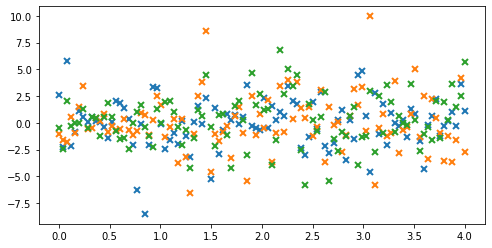

In [144]:
plt.figure(figsize=(8, 4))
plt.plot(Xa,Ya,"x", mew=2)
_ = plt.plot(Xb,Yb, "x", mew=2)
_ = plt.plot(Xc,Yc, "x", mew=2)

In [145]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.vstack((np.hstack((Xa, np.zeros_like(Xa))), np.hstack((Xb, np.ones_like(Xb))))),np.hstack((Xc, np.ones_like(Xc)*2))))

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y_augmented = np.vstack((np.vstack((np.hstack((Ya, np.zeros_like(Ya))), np.hstack((Yb, np.ones_like(Yb))))),np.hstack((Yc, np.ones_like(Yc)*2))))




In [196]:
output_dim = 3  # Number of outputs
rank = 1 # Rank of W:  it is the number of degrees of correlation between the outputs.

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Coregion kernel
coreg1 = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])
coreg2 =  gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])
changep = gpflow.kernels.ChangePoints([coreg1, coreg2], [2.0], steepness=5.0, name=None)
kern = k * coreg1 #changep

In [198]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = ci_niter(10000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

      fun: 680.5672320636007
 hess_inv: <45461x45461 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.01843451e-03, 4.50404940e-03, 1.52887813e-03, ...,
       1.28140955e-06, 8.24050716e-06, 1.96227181e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 170
      nit: 144
     njev: 170
   status: 0
  success: True
        x: array([-3.86662410e+00, -3.69518137e+00,  1.74926130e+00, ...,
       -4.48019820e-04, -1.16172817e-02,  9.55539613e-01])

tf.Tensor(
[[-0.46298867]
 [-2.21410812]
 [ 1.79897284]
 [-0.27490616]
 [-0.08730056]
 [ 0.03201373]
 [ 1.22096895]
 [-0.42723566]
 [ 0.43764576]
 [ 0.3899919 ]
 [-1.08459235]
 [ 0.47855945]
 [ 1.6086069 ]
 [ 0.45227943]
 [-0.68697769]
 [-1.33093543]
 [-1.28646781]
 [-2.14355465]
 [-0.08396455]
 [ 0.8130829 ]
 [ 1.46870794]
 [-0.41405828]
 [-1.1509609 ]
 [-1.90441115]
 [ 1.25360848]
 [ 0.09480372]
 [ 1.69590383]
 [ 1.81621119]
 [ 0.89260687]
 [-0.49494497]
 [-1.78571182]
 [-0.75837467]
 [-3.96379506]
 [-1.3194257 ]
 [ 1.13454978]
 [ 0.79783236]
 [ 4.25268255]
 [-0.55060643]
 [-1.88293862]
 [ 0.55397359]
 [ 0.7045114 ]
 [-1.08064162]
 [-3.81824266]
 [ 1.3467497 ]
 [ 1.85976659]
 [ 0.16163728]
 [-2.67853165]
 [ 4.11727486]
 [ 1.54136786]
 [ 2.42264254]
 [ 1.15865126]
 [ 1.17552109]
 [-3.5764617 ]
 [-1.38891844]
 [ 6.15336959]
 [ 2.47807341]
 [ 4.6729336 ]
 [ 3.19703268]
 [ 4.11461101]
 [-2.21254938]
 [-5.12308042]
 [ 1.51652736]
 [ 0.19788707]
 [-0.68773662]
 [ 0.61405839]
 [ 2.28289451]

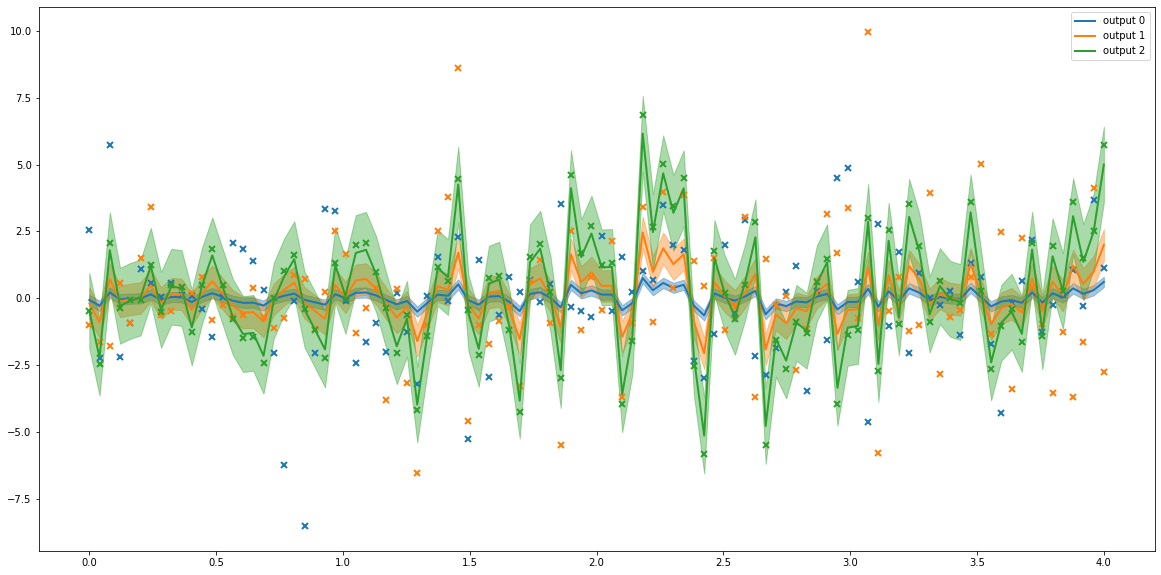

In [224]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(Xtest, mus, vs, X, Y):
    plt.figure(figsize=(20, 10))
    for i, (mu, var) in enumerate(zip(mus, vs)):
        (line,) = plt.plot(X[:,i], Y[:,i], "x", mew=2)
        label = "output " + str(i)
        plot_gp( Xtest, mu, var ,line.get_color(), label)
    plt.legend()

Xtest = np.linspace(0,4,100)[:,None]
mus = []
vs=  []
for out in range(output_dim):
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest)*out)))
    mus.append(mu)
    vs.append(var)
plot(Xtest, mus, vs, X , Y)

B = [[ 8.84724908e-07 -1.26082782e-08 -6.65089677e-07]
 [-1.26082782e-08  1.07653029e-06  3.02531449e-07]
 [-6.65089677e-07  3.02531449e-07  2.18462903e-05]]


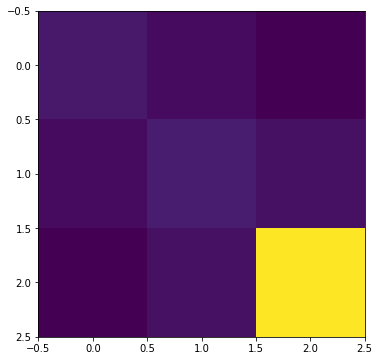

In [187]:
B = coreg.output_covariance().numpy()
print("B =", B)
_ = plt.imshow(B)

In [189]:
K = k.numpy()
print("B =", B)
_ = plt.imshow(B)

AttributeError: 'Matern32' object has no attribute 'numpy'

Experimental mogp 


In [177]:
output_dim = 3  # Number of outputs
rank = 1 # Rank of W:  it is the number of degrees of correlation between the outputs.

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])

kern = k # coreg

TypeError: can only combine Kernel instances

In [ ]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = ci_niter(10000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

# 4 MGARCH

In [150]:
#source: https://quant.stackexchange.com/questions/20687/multivariate-garch-in-python


In [153]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as objects 

import numpy as np
import pandas as pd
from rpy2.robjects.conversion import localconverter

df = pd.DataFrame(Y, columns = ['Column_A','Column_B','Column_C'])
pd_rets = pd.DataFrame(df)

# compute DCC-Garch in R using rmgarch package
pandas2ri.activate()
with localconverter(objects.default_converter + pandas2ri.converter):
    r_rets = objects.conversion.py2rpy(pd_rets)
 # convert the daily returns from pandas dataframe in Python to dataframe in R
r_dccgarch_code = """
                library('rmgarch')
                function(r_rets, n_days){
                        univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                                                    variance.model = list(garchOrder = c(1,1),
                                                                        variance.targeting = FALSE, 
                                                                        model = "sGARCH"),
                                                    distribution.model = "norm")
                        n <- dim(r_rets)[2]
                        dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)),
                                            dccOrder = c(1,1),
                                            distribution = "mvnorm")
                        dcc_fit <- dccfit(dcc_spec, data=r_rets)
                        forecasts <- dccforecast(dcc_fit, n.ahead = n_days)
                        list(dcc_fit, forecasts@mforecast$H)
                }
                """
r_dccgarch = objects.r(r_dccgarch_code)
n_days= 5
r_res = r_dccgarch(r_rets,n_days)
pandas2ri.deactivate()
# end of R

r_dccgarch_model = r_res[0] # model parameters
r_forecast_cov = r_res[1] # forecasted covariance matrices for n_days
print(r_forecast_cov)
# access and transform the covariance matrices in R format
n_cols = pd_rets.shape[1] # get the number of stocks in pd_rets
n_elements = n_cols*n_cols # the number of elements in each covariance matrix
n_matrix = int(len(r_forecast_cov[0])/(n_elements))
print(n_matrix) # this should be equal to n_days

# sum the daily forecasted covariance matrices 
cov_matrix = 0
for i in range(n_matrix):
    i_matrix = np.array([v for v in r_forecast_cov[0][i*n_elements:(i+1)*n_elements]])
    i_matrix = i_matrix.reshape(n_cols,n_cols)    
    cov_matrix += i_matrix

[[0.         0.         0.        ]
 [0.04040404 0.04040404 0.04040404]
 [0.08080808 0.08080808 0.08080808]
 [0.12121212 0.12121212 0.12121212]
 [0.16161616 0.16161616 0.16161616]
 [0.2020202  0.2020202  0.2020202 ]
 [0.24242424 0.24242424 0.24242424]
 [0.28282828 0.28282828 0.28282828]
 [0.32323232 0.32323232 0.32323232]
 [0.36363636 0.36363636 0.36363636]
 [0.4040404  0.4040404  0.4040404 ]
 [0.44444444 0.44444444 0.44444444]
 [0.48484848 0.48484848 0.48484848]
 [0.52525253 0.52525253 0.52525253]
 [0.56565657 0.56565657 0.56565657]
 [0.60606061 0.60606061 0.60606061]
 [0.64646465 0.64646465 0.64646465]
 [0.68686869 0.68686869 0.68686869]
 [0.72727273 0.72727273 0.72727273]
 [0.76767677 0.76767677 0.76767677]
 [0.80808081 0.80808081 0.80808081]
 [0.84848485 0.84848485 0.84848485]
 [0.88888889 0.88888889 0.88888889]
 [0.92929293 0.92929293 0.92929293]
 [0.96969697 0.96969697 0.96969697]
 [1.01010101 1.01010101 1.01010101]
 [1.05050505 1.05050505 1.05050505]
 [1.09090909 1.09090909 1.09

# 5 results

Below are functions used for **plotting**

In [154]:
def plot_loss(num_iter, loss):
    x = np.linspace(1, num_iter, len(loss))
    fig = plt.figure()
    plt.plot(x, loss, label='ELBO')
    plt.xlim([x[0], x[-1]])
    plt.xlabel('Iteration')
    plt.ylabel('ELBO')
    plt.title('Training convergence')
    plt.tight_layout()


#
def plot_wishart_process_sample(X, Sigma):
    N, D, _ = Sigma.shape
    c1 = '#363537'
    c2 = '#EF2D56'
    fig, axes = plt.subplots(nrows=D, ncols=D, sharex=True, sharey=True, figsize=(10, 10))
    x = X[:, 0]

    for i in range(D):
        for j in range(D):
            ax = axes[i, j]
            if j < i:
                ax.axis('off')
            else:
                ax.plot(x, Sigma[:, i, j], color=c1, lw=2, label='Ground truth')
                ax.set_xlim([x[0], x[-1]])
                ax.set_title('$\sigma_{{{:d},{:d}}}(t)$'.format(i + 1, j + 1), fontsize=20)
    return fig, axes


#
def plot_wishart_predictions(samples, X, axes=None, plot_individuals=0):
    posterior_expectation = tf.reduce_mean(samples, axis=0).numpy()
    posterior_variance = tf.math.reduce_variance(samples, axis=0).numpy()

    c1 = '#363537'
    c2 = '#EF2D56'

    _, D = X.shape
    x = X[:, 0]
    if axes is None:
        fig, axes = plt.subplots(nrows=D, ncols=D, sharex=True, sharey=True, figsize=(10, 10))

    for i in range(D):
        for j in range(D):
            ax = axes[i, j]
            if j < i:
                ax.axis('off')
            else:
                mean = posterior_expectation[:, i, j]
                intv = 1.96*np.sqrt(posterior_variance[:, i, j])
                ax.plot(x, mean, lw=2, c=c2, label='BANNER posterior mean')
                ax.fill_between(x, mean - intv, mean + intv, color=c2, alpha=0.2, label='BANNER 95\% HDI')
                if plot_individuals > 0:
                    ixs = np.random.randint(0, samples.shape[0], size=plot_individuals)
                    for ix in ixs:
                        ax.plot(x, samples[ix, :, i, j].numpy(), c=c2, alpha=0.4, lw=0.5)
                ax.set_xlim([x[0], x[-1]])


╒══════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤══════════════╤═════════╤════════════════════════════════════════════════════════╕
│ name                                                 │ class     │ transform      │ prior   │ trainable   │ shape        │ dtype   │ value                                                  │
╞══════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪══════════════╪═════════╪════════════════════════════════════════════════════════╡
│ WishartProcess.kernel.kernels[0].kernel.variance     │ Parameter │ Softplus       │         │ True        │ ()           │ float64 │ 0.5140317101024595                                     │
├──────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼──────────────┼─────────┼────────────────────────────────────────────────────────┤
│ WishartProcess.kernel.kernels[0].kerne

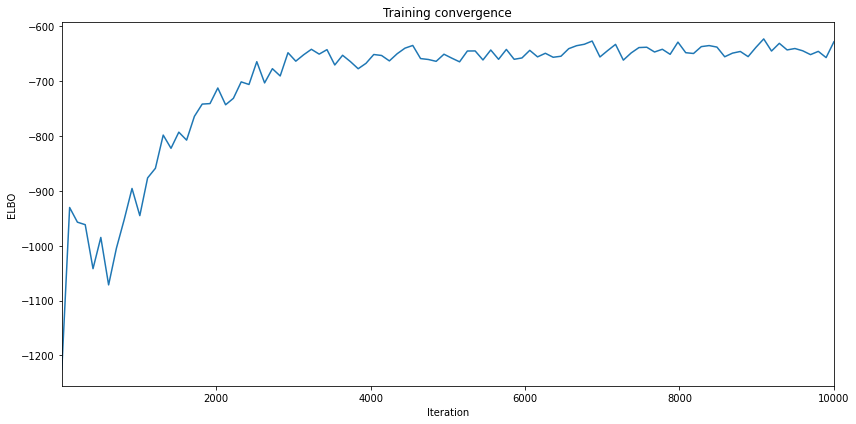

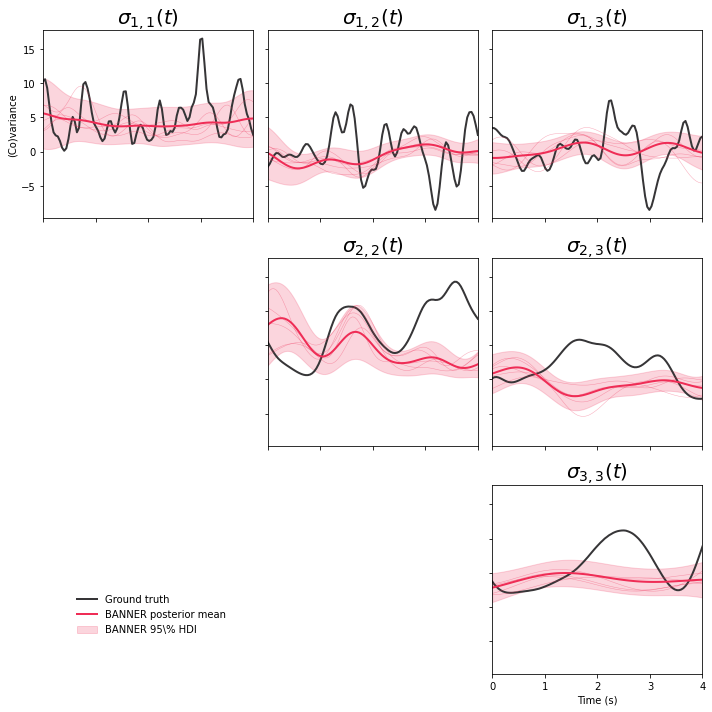

Variable 0
True lengthscale: 0.200
Estimated lengthscale: 0.758
True variance: 1.247
Estimated variance: 0.514
Variable 1
True lengthscale: 0.700
Estimated lengthscale: 0.979
True variance: 1.208
Estimated variance: 0.920
Variable 2
True lengthscale: 1.200
Estimated lengthscale: 2.935
True variance: 1.349
Estimated variance: 0.847


In [155]:
elbo = gwp_results['ELBO']

print_summary(posterior_wishart_process)
plot_loss(num_iter, elbo)

num_samples = 5000

fig, axes = plot_wishart_process_sample(X, Sigma_true)
samples = posterior_wishart_process.predict_mc(X, num_samples) #(num_samples, N, D, D)
plot_wishart_predictions(samples=samples, X=X, axes=axes, plot_individuals=5)
# plot_sliding_window(sliding_window_inv_wishart_mean, sliding_window_inv_wishart_var, axes=axes)

axes[-1, -1].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('(Co)variance')
handles, labels = axes[-1, -1].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=1, loc='lower left', bbox_to_anchor=(0.1, 0.10), frameon=False)
plt.tight_layout()
plt.show()

for i in range(D):
    print('Variable {:d}'.format(i))
    print('True lengthscale: {:0.3f}'.format(true_lengthscale[i]))
    print('Estimated lengthscale: {:0.3f}'.format(posterior_wishart_process.kernel.kernels[i].kernel.lengthscales.numpy().item()))
    print('True variance: {:0.3f}'.format(true_variance[i]))
    print('Estimated variance: {:0.3f}'.format(posterior_wishart_process.kernel.kernels[i].kernel.variance.numpy().item()))

In [226]:
mu , var =  posterior_wishart_process.predict_f(None)
print_summary(posterior_wishart_process)
print(mu.shape)
print(var.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

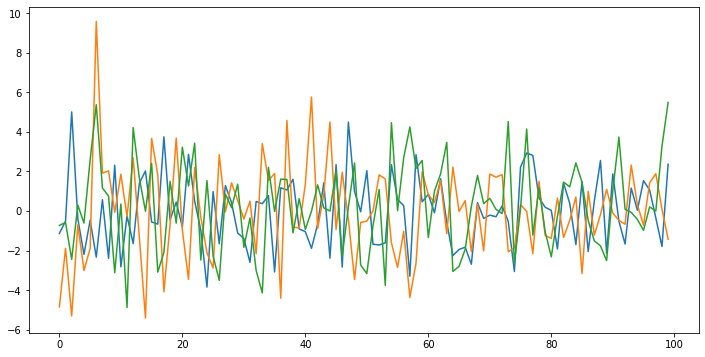

In [214]:

posterior_expectation = tf.reduce_mean(samples, axis=0).numpy()
posterior_variance = tf.math.reduce_variance(samples, axis=0).numpy()

Y_test = sample_observations(posterior_expectation, mu=None)